# Calculations with Reference States

## Experimental Reference States: Formation and Mixing Energy

By default, energies calculated with pycalphad (e.g. `GM`, `HM`, etc.) are the absolute energies as defined in the database and are not calculated with respect to any reference state.

pycalphad `Model` objects allows the reference phase for the pure components to be set to arbitrary phases and temperature/pressure conditions through the `shift_reference_state` method, which creates new properties for the energies that are referenced to the new reference state, `GMR`, `HMR`, `SMR`, and `CPMR`.

### Enthalpy of mixing

The enthalpy of mixing in the liquid, analogous to what would be measure experimentally, is calculated plotted below with the reference states of the pure elements both set to the liquid phase. No temperature and pressure are specified as we would like the reference state to be calculated with respect to the calculation temperature.

In [1]:
%matplotlib inline

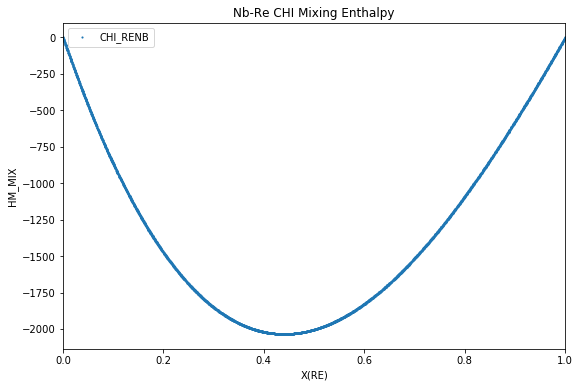

In [2]:
from pycalphad import Database, calculate, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt

dbf = Database("nbre_liu.tdb")
comps = ["NB", "RE", "VA"]

# Create reference states
Nb_ref = ReferenceState("NB", "LIQUID_RENB")
Re_ref = ReferenceState("RE", "LIQUID_RENB")
liq_refstates = [Nb_ref, Re_ref]

# Create the model and shift the reference state
mod_liq = Model(dbf, comps, "LIQUID_RENB")
mod_liq.shift_reference_state(liq_refstates, dbf)
calc_models = {"LIQUID_RENB": mod_liq}

# Calculate HMR for the liquid at 2800 K from X(RE)=0 to X(RE)=1
conds = {v.P: 101325, v.T: 2800, v.X("RE"): (0, 1, 0.01)}
result = calculate(dbf, comps, "LIQUID_RENB", P=101325, T=2800, output="HMR", model=calc_models)

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.scatter(result.X.sel(component='RE'), result.HMR, marker='.', s=5, label='CHI_RENB')
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.set_ylabel('HM_MIX')
ax.set_title('Nb-Re CHI Mixing Enthalpy')
ax.legend()
plt.show()

### Enthalpy of formation - convex hull

Formation enthalpies are often reported in the literature with respect to the pure elements in their stable phase at 298.15 K. The enthalpy of formation of the phases in equilibrium, analogous to what would be measured experimentally, is calculated and plotted below for T=2800 K, with the reference states of the pure elements both set to the pure elements at 298.15 K and 1 atm.

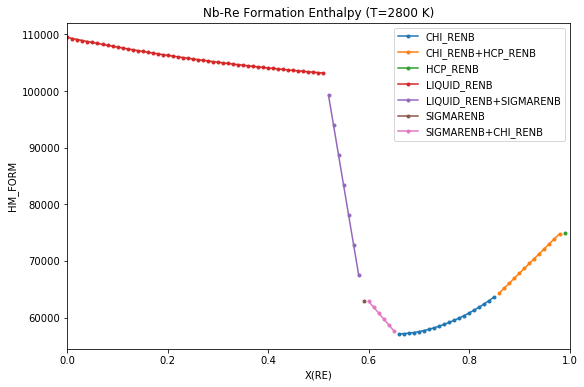

In [3]:
from pycalphad import Database, equilibrium, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt
import numpy as np

dbf = Database("nbre_liu.tdb")
comps = ["NB", "RE", "VA"]
phases = dbf.phases.keys()

# Create reference states
Nb_ref = ReferenceState("NB", "BCC_RENB", {v.T: 298.15, v.P: 101325})
Re_ref = ReferenceState("RE", "HCP_RENB", {v.T: 298.15, v.P: 101325})

# Create the models for each phase and shift them all by the same reference states.
eq_models = {}
for phase_name in phases:
    mod = Model(dbf, comps, phase_name)
    mod.shift_reference_state([Nb_ref, Re_ref], dbf)
    eq_models[phase_name] = mod

# Calculate HMR at 2800 K from X(RE)=0 to X(RE)=1
conds = {v.P: 101325, v.T: 2800, v.X("RE"): (0, 1, 0.01)}
result = equilibrium(dbf, comps, phases, conds, output="HMR", model=eq_models)

# Find the groups of unique phases in equilibrium e.g. [CHI_RENB] and [CHI_RENB, HCP_RENB]
unique_phase_sets = np.unique(result.Phase.values.squeeze(), axis=0)

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same unique phase
    unique_phase_idx = np.nonzero(np.all(result.Phase.values.squeeze() == phase_set, axis=1))[0]
    masked_result = result.isel(X_RE=unique_phase_idx)
    ax.plot(masked_result.X_RE.squeeze(), masked_result.HMR.squeeze(), marker='.', label=label)
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.set_ylabel('HM_FORM')
ax.set_title('Nb-Re Formation Enthalpy (T=2800 K)')
ax.legend()
plt.show()

## Special `_MIX` Reference State

pycalphad also includes special mixing reference state that is referenced to the endmembers for that phase with the `_MIX` suffix (`GM_MIX`, `HM_MIX`, `SM_MIX`, `CPM_MIX`). This is particularly useful for seeing how the mixing contributions from physical or excess models affect the energy. The `_MIX` properties are set by default and no instantiation of `Model` objects and calling `shift_reference_state` is required.

Below is an example for calculating this endmember-referenced mixing enthalpy for the $\chi$ phase in Nb-Re. Notice that the four endmembers have a mixing enthalpy of zero.

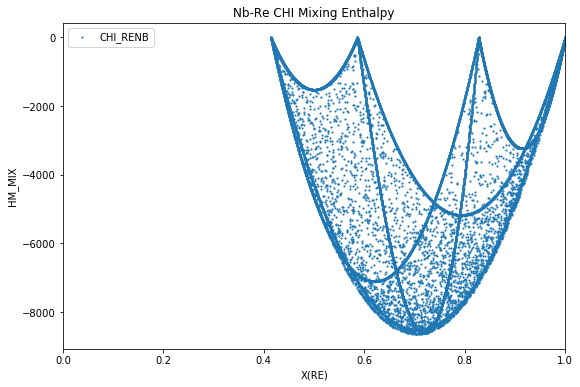

In [4]:
from pycalphad import Database, calculate
import matplotlib.pyplot as plt

dbf = Database("nbre_liu.tdb")
comps = ["NB", "RE", "VA"]

# Calculate HMR for the Chi at 2800 K from X(RE)=0 to X(RE)=1
result = calculate(dbf, comps, "CHI_RENB", P=101325, T=2800, output='HM_MIX')

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.scatter(result.X.sel(component='RE'), result.HM_MIX, marker='.', s=5, label='CHI_RENB')
ax.set_xlim((0, 1))
ax.set_xlabel('X(RE)')
ax.set_ylabel('HM_MIX')
ax.set_title('Nb-Re CHI Mixing Enthalpy')
ax.legend()
plt.show()